In [97]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
save_path = r'/Users/nikolaibeckjensen/Desktop/Figurer - Deskriptiv Analyse'

## **Exploratory Analysis**

This notebook serves to investigate the virk data prior to defining the token-vocabulary used to describe company life events.



#### *Filtering the data*
For this analysis, we look at CVR-numbers who fulfill the following criteria:
- Has published 5 or more annual financial reports in the periode 2013-2023

In [176]:
def load_all_chunks_from_folder(folder) -> pd.DataFrame:
    df = pd.DataFrame()
    for file in os.listdir(folder):
        if file.endswith('.csv'):
            df_chunk = pd.read_csv(os.path.join(folder, file), index_col=0)
            df = pd.concat([df, df_chunk])

    return df
                                   

# load company info
company_info_folder = r'/Users/nikolaibeckjensen/Dropbox/Virk2Vec/Tables/CompanyInfo'
company_info_full = load_all_chunks_from_folder(company_info_folder)

# load financials
financials_folder = r'/Users/nikolaibeckjensen/Dropbox/Virk2Vec/xml_links'
financials = load_all_chunks_from_folder(financials_folder).dropna(subset=['CVR']).reset_index(drop=True)
financials['CVR'] = financials['CVR'].astype(int)

# get a list of CVR numbers with more than 5 reports
cvr_counts = financials['CVR'].value_counts()
cvr_list = cvr_counts[cvr_counts >= 5].index.to_list()

#filter out companies with less than 5 reports in company_info
company_info = company_info_full[company_info_full['CVR'].isin(cvr_list)].reset_index(drop=True)

# also fetch the companies with less than 5 reports
company_info_low = company_info_full[~company_info_full['CVR'].isin(cvr_list)].reset_index(drop=True)

del financials
del company_info_full


In [105]:
print("Number of companies with more than 5 reports: ", len(company_info))
print("Share of active companies:", company_info.EndDate.isna().sum()/len(company_info))

Number of companies with more than 5 reports:  282157
Share of active companies: 0.8035526320452797


### **Company Info**

Lets first investigate the subset of CVRs.
- Distribution of company types
- Distribution of status
- Distribution of company age (split on alive and "dead")


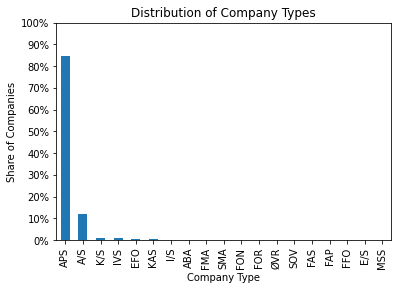

In [106]:
company_info.CompanyType.value_counts(normalize=True).plot(kind='bar')
plt.yticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']);
plt.xlabel('Company Type')
plt.ylabel('Share of Companies')
plt.title('Distribution of Company Types')

# save fig
plt.savefig(os.path.join(save_path, 'CompanyTypeDistribution.png'))


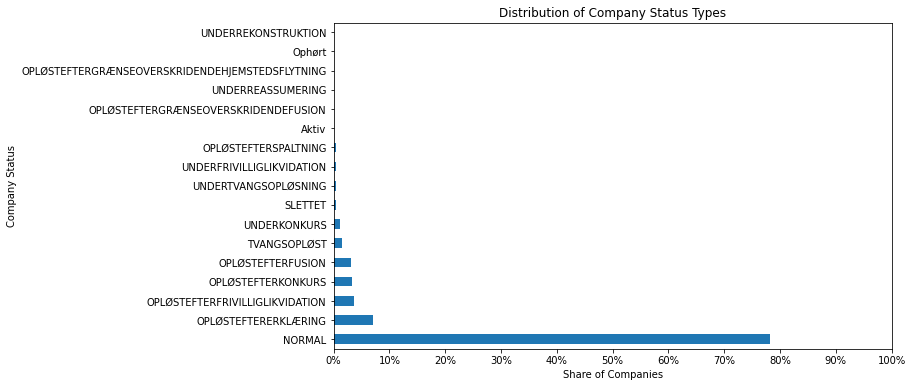

In [107]:
plt.figure(figsize=(10, 6))
company_info.Status.value_counts(normalize=True).plot(kind='barh')
plt.xticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.ylabel('Company Status')
plt.xlabel('Share of Companies')
plt.title('Distribution of Company Status Types')

# save fig
plt.savefig(os.path.join(save_path, 'CompanyStatusDistribution.png'), bbox_inches='tight')

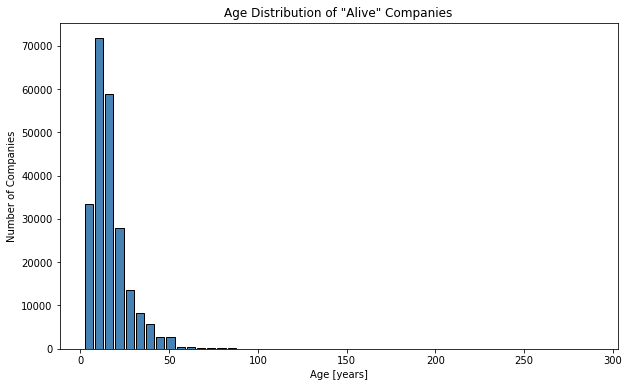

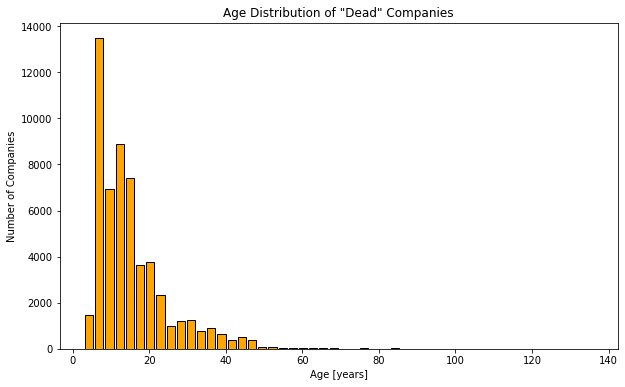

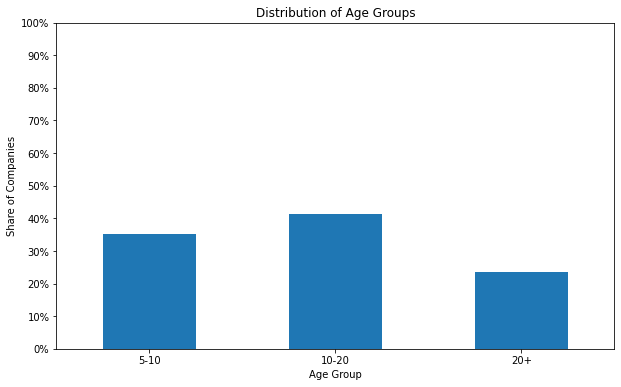

In [108]:
def age(start_date: str, end_date: str) -> int:
    try:
        age = int(end_date[:4]) - int(start_date[:4])
    except:
        age = None
    return age

company_info['Age'] = company_info.apply(lambda x: age(x['StartDate'], "2024-09-01") if pd.isna(x['EndDate']) else age(x['StartDate'], x['EndDate']), axis=1)

# plot age distribution for "alive" companies (i.e. companies with no end date)
plt.figure(figsize=(10, 6))  # Increase figure size
company_info[company_info.EndDate.isna()]['Age'].plot(
    kind='hist',
    bins=50,
    edgecolor='black',  # Color of the border
    color='steelblue',  # Color of the bins
    rwidth=0.8  # Space between bins
)
plt.xlabel('Age [years]')
plt.ylabel('Number of Companies')
plt.title('Age Distribution of "Alive" Companies')
# save fig
plt.savefig(os.path.join(save_path, 'AgeDistributionAliveCompanies.png'))

# plot age distribution for "dead" companies (i.e. companies with an end date)
plt.figure(figsize=(10, 6))  # Increase figure size
company_info[~company_info.EndDate.isna()]['Age'].plot(
    kind='hist',
    bins=50,
    edgecolor='black',  # Color of the border
    color='orange',  # Color of the bins
    rwidth=0.8  # Space between bins
)
plt.xlabel('Age [years]')
plt.ylabel('Number of Companies')
plt.title('Age Distribution of "Dead" Companies')
# save fig
plt.savefig(os.path.join(save_path, 'AgeDistributionDeadCompanies.png'))


# make custom bins to use in a bar chart
custom_bins = ['5-10', '10-20', '20+']
company_info['AgeGroup'] = pd.cut(company_info['Age'], bins=[5, 10, 20, 100], labels=custom_bins)

# plot age group distribution
plt.figure(figsize=(10, 6)) 
company_info['AgeGroup'].value_counts(normalize=True).loc[custom_bins].plot(kind='bar')
plt.yticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']);
plt.xlabel('Age Group')
plt.ylabel('Share of Companies')
plt.title('Distribution of Age Groups')
plt.xticks(rotation=0)

# save fig
plt.savefig(os.path.join(save_path, 'AgeGroupDistribution.png'))


Quite a large share of companies have a long history - this highlights the importance of the 'background sentence'

#### Industry codes

In [113]:
company_info = company_info.dropna(subset=['IndustryCode'])

In [114]:
company_info['IndustryCode'] = company_info.IndustryCode.astype(int).astype(str)
company_info['IndustryCode4'] = company_info['IndustryCode'].str[:4]
company_info['IndustryCode2'] = company_info['IndustryCode'].str[:2]

/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_60099/1349250331.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info['IndustryCode'] = company_info.IndustryCode.astype(int).astype(str)
/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_60099/1349250331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info['IndustryCode4'] = company_info['IndustryCode'].str[:4]
/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_60099/1349250331.py:3: SettingWithCopyWarning: 

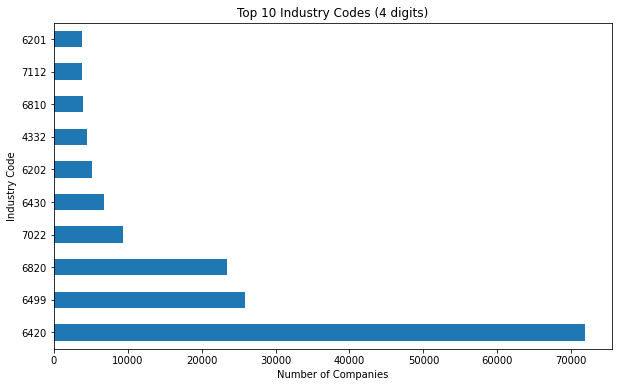

In [115]:
plt.figure(figsize=(10, 6))
company_info['IndustryCode4'].value_counts()[:10].plot(kind='barh')  # Swap 'bar' with 'barh'
plt.xlabel('Number of Companies')
plt.ylabel('Industry Code')  # Swap x and y axis labels
plt.title('Top 10 Industry Codes (4 digits)')

# save fig
plt.savefig(os.path.join(save_path, 'Top10IndustryCodes.png'))

### **1. Event type:** *Employee Counts*

Companies are required to announce their employee (FTE) count to the authorities. It seems that some update the count with varying frequency (monthly, quarterly, yearly)
We thus want to:
1. Investigate the frequency of updates (**done**)
2. Investigate if certain company types update more frequently than others (**TODO**)
3. Investigate the distribution of employee counts (continuous variable) (**done**)
4. Investigate the distribution of employee growth (**TODO**)


In [160]:
# load the data
employee_folder = r'/Users/nikolaibeckjensen/Dropbox/Virk2Vec/Tables/EmployeeCounts'
df_employee = load_all_chunks_from_folder(employee_folder)
print(len(df_employee))
df_employee['Year'] = df_employee.FromDate.str[:4]

# filter out companies with less than 5 reports
df_employee = df_employee[df_employee['CVR'].isin(cvr_list)].reset_index(drop=True)

14909725


#### **1a**. Investigate the frequency of updates

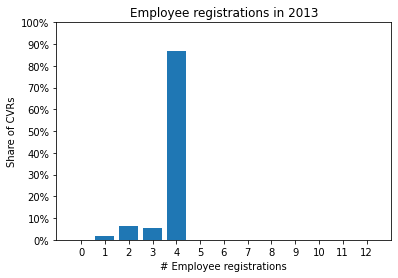

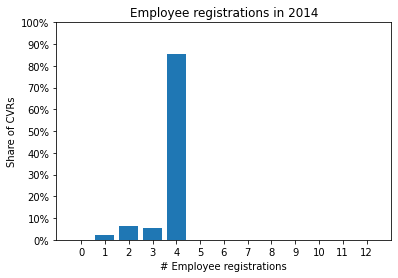

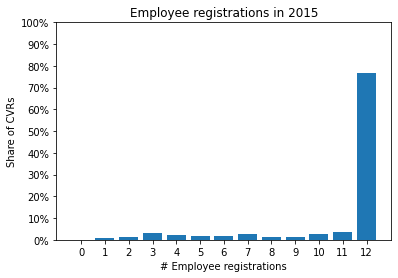

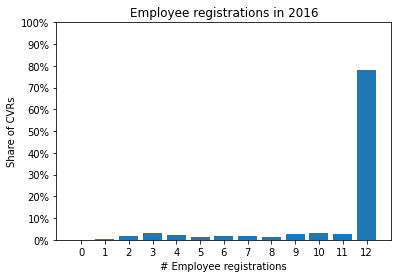

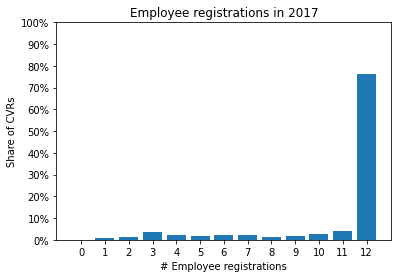

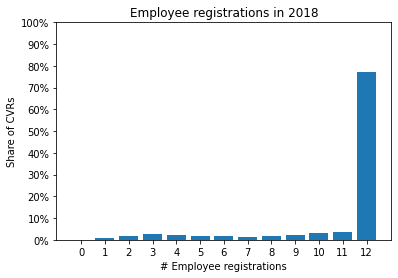

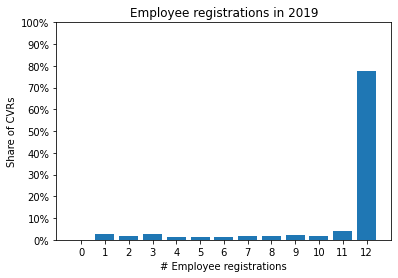

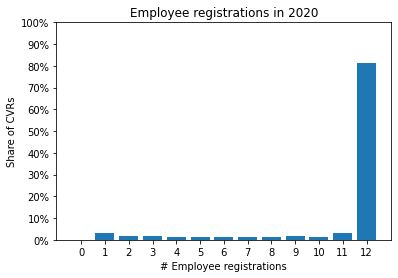

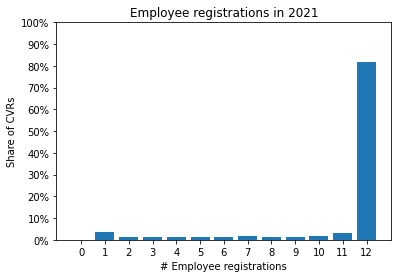

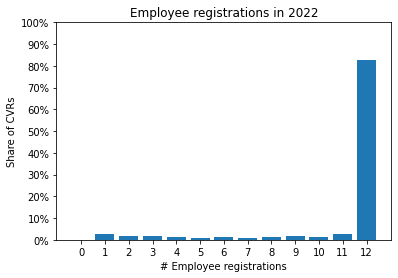

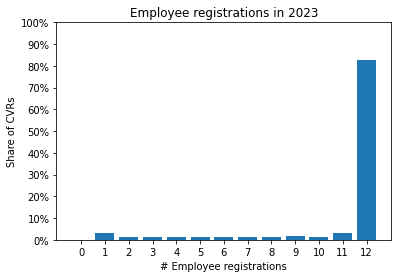

In [8]:
registrations_per_year = df_employee.value_counts(subset=['Year', 'CVR']) 

for year in range(2013,2024):
    plt.figure()
    # create lists for bar plot
    x = list(range(0,13))
    y = []

    # fetch all values for 2021
    registrations = registrations_per_year.loc[str(year)].value_counts(normalize=True)

    for idx in x:
        if idx not in registrations.index:
            y.append(0)
        else:
            y.append(registrations[idx])

    # plot the data
    plt.bar(x, y)
    plt.xlabel('# Employee registrations')
    plt.ylabel('Share of CVRs')
    plt.title(f'Employee registrations in {year}')
    plt.xticks(x);
    plt.yticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']);

A clear change in reporting requirements can be seen from 2014-2015. Goes from quarterly being the norm to yearly.

Lets look at the total distribution for registration events

Text(0.5, 1.0, 'Distribution of EmployeeCount Registrations')

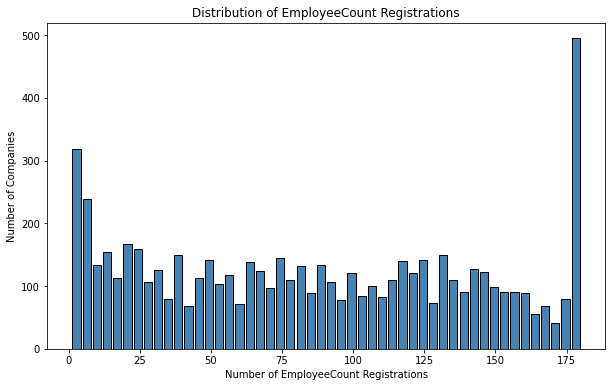

In [9]:
registrations = df_employee.loc[df_employtee. ]groupby("CVR").size().values

# plot the distribution of number of registrations
plt.figure(figsize=(10, 6))
plt.hist(registrations, bins=50, edgecolor='black', color='steelblue', rwidth=0.8);
plt.xlabel('Number of EmployeeCount Registrations')
plt.ylabel('Number of Companies')
plt.title('Distribution of EmployeeCount Registrations')


Interesting huge peak in the end. Why?

In [10]:
df_employee.groupby("CVR").size().value_counts()

180    390
2       88
1       82
3       82
6       71
      ... 
176     10
151     10
163      9
159      9
171      8
Length: 180, dtype: int64

A significant number of companies have 180 registrations. Lets link to the company info table to find out if these in particular have something in common.

In [11]:
registrations_per_cvr = df_employee.groupby("CVR").size().reset_index().rename(columns={0: 'EmployeeRegistrations'})

# left join onto company_info, replace NaN with 0
company_info = company_info.merge(registrations_per_cvr, how='left', left_on='CVR', right_on='CVR')
company_info['EmployeeRegistrations'] = company_info['EmployeeRegistrations'].fillna(0)
company_info.loc[company_info['EmployeeRegistrations'] == 180]

,CVR,Name,StartDate,EndDate,CompanyType,CompanyTypeCode,ProductionUnits,ZipCode,Industry,IndustryCode,Status,Age,AgeGroup,EmployeeRegistrations
241,11007287,KNUD THOMSEN FISKEEKSPORT A/S,1987-05-27,NaN,A/S,60.0,1.0,9970.0,Engroshandel med fisk og fiskeprodukter,463810.0,NORMAL,37,20+,180.0
313,13118590,FREMTIDEN STALDINVENTAR A/S,1989-05-01,NaN,A/S,60.0,1.0,8870.0,Fremstilling af metalkonstruktioner og dele heraf,251100.0,NORMAL,35,20+,180.0
314,13220034,R-INVEST ApS AF 1/4 1989,1989-04-01,NaN,APS,80.0,2.0,1620.0,"Cafeér, værtshuse, diskoteker mv.",563000.0,NORMAL,35,20+,180.0
315,12516770,FLEX TRADING. RANDERS A/S,1988-09-01,NaN,A/S,60.0,1.0,8920.0,"Engroshandel med landbrugsmaskiner, -udstyr og...",466100.0,NORMAL,36,20+,180.0
335,10360447,ApS JOHN OLSEN EL-INSTALLATIONER,1986-02-05,NaN,APS,80.0,1.0,2610.0,El-installation,432100.0,NORMAL,38,20+,180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11679,20392096,CAFE VIGGO. AARHUS A/S,1997-05-12,NaN,A/S,60.0,1.0,8000.0,"Cafeér, værtshuse, diskoteker mv.",563000.0,NORMAL,27,20+,180.0
11731,75162014,COLUMBUS TRADING A/S,1984-06-29,NaN,A/S,60.0,1.0,3600.0,"Engroshandel med cykler, sportsartikler og lys...",464910.0,NORMAL,40,20+,180.0
11733,10114241,DECHRA VETERINARY PRODUCTS A/S,1986-02-21,NaN,A/S,60.0,2.0,7171.0,Engroshandel med medicinalvarer og sygeplejear...,464610.0,NORMAL,38,20+,180.0
11735,17642499,POUL IVERSEN MENSWEAR A/S,1994-01-01,NaN,A/S,60.0,1.0,7100.0,Tøjforretninger,477110.0,NORMAL,30,20+,180.0


It seems that companies with 180 employee registrations are all in AgeGroup 20+. Thus, they have existed before registering the number of employees was required and have all begun registering at the same time. 


Weirdly enough, some companies have 0 EmployeeRegistrations. Is this a bug in our code or something else causing it?

In [14]:
entries_with_no_employees = len(company_info.loc[company_info['EmployeeRegistrations'] == 0])
print("Share of companies with no employee registrations: ", entries_with_no_employees / len(company_info))

company_info.loc[company_info['EmployeeRegistrations'] == 0].sample(10)

Share of companies with no employee registrations:  0.476423863444313


,CVR,Name,StartDate,EndDate,CompanyType,CompanyTypeCode,ProductionUnits,ZipCode,Industry,IndustryCode,Status,Age,AgeGroup,EmployeeRegistrations
1827,38731793,IHP Familiefond ApS,2017-06-15,NaN,APS,80.0,1.0,4360.0,Ikke-finansielle holdingselskaber,642020.0,NORMAL,7,5-10,0.0
4951,28963653,BOJA HOLDING ApS,2005-08-02,2018-01-16,APS,80.0,1.0,4400.0,Uoplyst,999999.0,OPLØSTEFTERERKLÆRING,13,10-20,0.0
2090,36735384,JJUUL ApS,2015-05-05,NaN,APS,80.0,1.0,4171.0,Ikke-finansielle holdingselskaber,642020.0,NORMAL,9,5-10,0.0
8772,37811548,Maxie Holding ApS,2016-06-21,NaN,APS,80.0,1.0,5250.0,Ikke-finansielle holdingselskaber,642020.0,NORMAL,8,5-10,0.0
7335,38329936,JG 7117 ApS,2017-01-07,NaN,APS,80.0,1.0,7100.0,Ikke-finansielle holdingselskaber,642020.0,NORMAL,7,5-10,0.0
367,31770300,NAGEL HOLDING 2008 ApS,2008-09-18,NaN,APS,80.0,1.0,3230.0,Ikke-finansielle holdingselskaber,642020.0,NORMAL,16,10-20,0.0
7570,36441194,MANTHY HOLDING ApS,2014-11-21,NaN,APS,80.0,1.0,7441.0,Anden finansiel formidling undtagen forsikring...,649900.0,NORMAL,10,5-10,0.0
2941,25218728,EAH HOLDING ApS,2000-02-10,2018-04-03,APS,80.0,1.0,2960.0,Ikke-finansielle holdingselskaber,642020.0,OPLØSTEFTERERKLÆRING,18,10-20,0.0
8459,39298961,Smoxware ApS,2018-01-18,NaN,APS,80.0,1.0,3450.0,Ikke-finansielle holdingselskaber,642020.0,NORMAL,6,5-10,0.0
3129,31167426,OG SÅ DET LANGE ApS,2007-12-28,NaN,APS,80.0,1.0,8000.0,Anden finansiel formidling undtagen forsikring...,649900.0,NORMAL,17,10-20,0.0


It seems that the Industry Codes are very similar. Looks to be "Holdingselskaber"

Total share in this figure:  0.6127260436031773


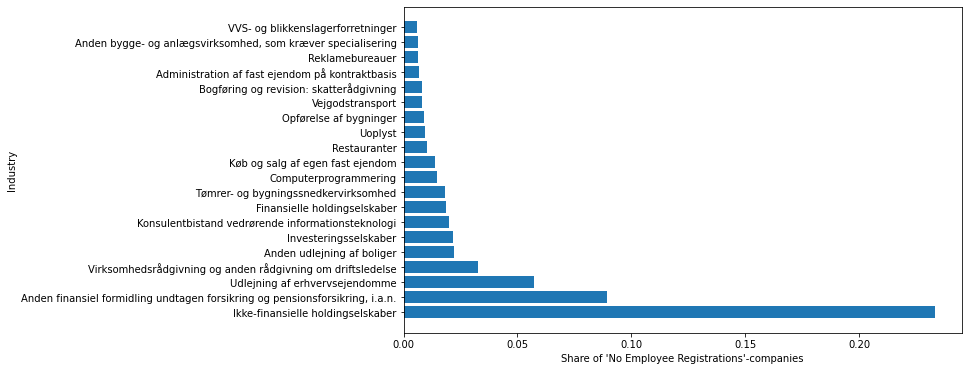

In [25]:
industries_without_employees = company_info.Industry.value_counts(normalize=True)

top_10_industries = industries_without_employees.values[:20]
top_10_industries_names = industries_without_employees.index[:20]

plt.figure(figsize=(10, 6))
plt.barh(top_10_industries_names, top_10_industries)
plt.xlabel("Share of 'No Employee Registrations'-companies")
plt.ylabel('Industry')

print("Total share in this figure: ", sum(top_10_industries))   


#### **1b**. Summary statistics + distribution of employee counts

In [61]:
# Summary statistics for employee counts
df_employee.EmployeeCounts.describe()

count    534504.000000
mean         15.767682
std         106.066331
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max       18104.000000
Name: EmployeeCounts, dtype: float64

Text(0.5, 1.0, 'Histogram of employee counts')

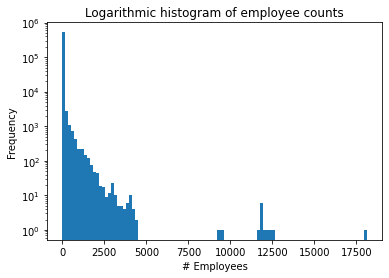

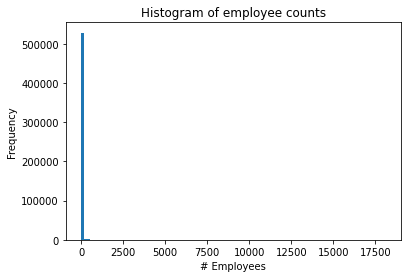

In [62]:
# logatrihmic plot of employee counts
plt.figure()
plt.hist(df_employee.EmployeeCounts, bins=100, log=True)
plt.xlabel('# Employees')
plt.ylabel('Frequency')
plt.title('Logarithmic histogram of employee counts')

# plot the distribution of employee counts
plt.figure()
plt.hist(df_employee.EmployeeCounts, bins=100)
plt.xlabel('# Employees')
plt.ylabel('Frequency')
plt.title('Histogram of employee counts')


Logarithmic distribution (?) - naturally a consequence of all companies starting with 0-1 employees and then gradually getting more. Only few companies managing to grow very large in size.

#### **1c**. Summary statistics and distribution of growth in employee counts

To mitigate that the employee count distribution is skewed by time (e.g. older companies are overrepresented), let's instead look at the largest registered number of employees for each company.

This shows more clearly, the range of growth in number of employees.

Text(0.5, 1.0, 'Logarithmic histogram of highest number of employees')

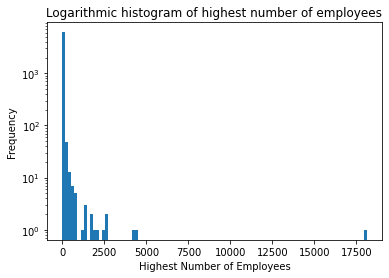

In [65]:
df_employee.groupby('CVR').max().EmployeeCounts.plot(kind='hist', bins=100, log=True)
plt.xlabel('Highest Number of Employees')
plt.ylabel('Frequency')
plt.title('Logarithmic histogram of highest number of employees')

Text(0.5, 1.0, 'Logarithmic histogram of highest number of employees [max < 2500]')

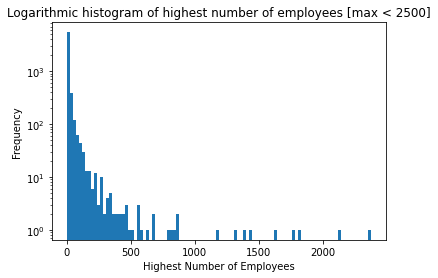

In [69]:
# filter out companies with max > 2500
df_employee_max = df_employee.groupby('CVR').max().reset_index()
df_employee_max[df_employee_max.EmployeeCounts < 2500].EmployeeCounts.plot(kind='hist', bins=100, log=True)
plt.xlabel('Highest Number of Employees')
plt.ylabel('Frequency')
plt.title('Logarithmic histogram of highest number of employees [max < 2500]')


In [71]:
# print each 10th percentile for the max employee counts
for i in range(0, 101, 10):
    print(f'{i}th percentile: {df_employee_max.EmployeeCounts.quantile(i/100)}')

0th percentile: 0.0
10th percentile: 1.0
20th percentile: 1.0
30th percentile: 1.0
40th percentile: 2.0
50th percentile: 4.0
60th percentile: 6.0
70th percentile: 8.0
80th percentile: 14.0
90th percentile: 28.0
100th percentile: 18104.0


#### **1d**. Summary statistics and distribution of latest employee count

In [161]:
# enrich company_info with the latest employee count
df_employee_latest = df_employee.sort_values('FromDate', ascending=False).groupby('CVR').first().reset_index().rename(columns={'EmployeeCounts': 'LatestEmployeeCount'})[['CVR', 'LatestEmployeeCount']]
company_info = company_info.merge(df_employee_latest, how='left', left_on='CVR', right_on='CVR')

In [163]:
company_info

,CVR,Name,StartDate,EndDate,CompanyType,CompanyTypeCode,ProductionUnits,ZipCode,Industry,IndustryCode,Status,Age,AgeGroup,IndustryCode4,IndustryCode2,LatestEmployeeCount_x,Registrations,LatestEmployeeCount_y
0,34580413,ANYWHERE ApS,2012-05-16,2019-12-19,APS,80.0,1.0,4000.0,Vejgodstransport,494100,OPLØSTEFTERKONKURS,7.0,5-10,4941,49,1.0,32.0,1.0
1,77767010,MORTEN SØRENSEN. THORNING ApS,1985-05-23,2019-02-14,APS,80.0,1.0,8800.0,"Udlejning og leasing af andet materiel, udstyr...",773900,OPLØSTEFTERERKLÆRING,34.0,20+,7739,77,0.0,0.0,NaN
2,34454558,MISTO ApS,2012-03-01,2018-05-30,APS,80.0,1.0,8000.0,"Pizzeriaer, grillbarer, isbarer mv.",561020,OPLØSTEFTERERKLÆRING,6.0,5-10,5610,56,1.0,23.0,1.0
3,32084567,A-ONE HOLDING ApS,2009-03-23,2018-08-28,APS,80.0,1.0,5700.0,Finansielle holdingselskaber,642010,OPLØSTEFTERERKLÆRING,9.0,5-10,6420,64,1.0,1.0,1.0
4,29919577,BNK INVEST ApS,2006-09-20,2019-01-29,APS,80.0,1.0,6857.0,"Udlejning af kontormaskiner og -udstyr, comput...",773300,OPLØSTEFTERERKLÆRING,13.0,10-20,7733,77,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282151,20145900,MM HOLDING GRENAA A/S,1997-06-24,NaN,A/S,60.0,1.0,8500.0,"Detailhandel med personbiler, varebiler og min...",451120,NORMAL,27.0,20+,4511,45,1.0,3.0,1.0
282152,78892528,NUUK IMEQ A/S,1985-09-01,NaN,A/S,60.0,1.0,3905.0,Fremstilling af læskedrikke: fremstilling af m...,110700,NORMAL,39.0,20+,1107,11,0.0,0.0,NaN
282153,36065168,codicu ApS,2014-08-13,NaN,APS,80.0,1.0,1311.0,Værdipapir- og varemægling,661200,NORMAL,10.0,5-10,6612,66,1.0,77.0,1.0
282154,26148804,TORNGAARD HEINEMANN MARKETING ApS,2001-07-10,NaN,APS,80.0,1.0,4000.0,Reklamebureauer,731110,NORMAL,23.0,20+,7311,73,1.0,122.0,1.0


In [162]:
#replace nan with 0
#company_info['LatestEmployeeCount'] = company_info['LatestEmployeeCount'].fillna(0)


# now look only at the actve companies
company_info_active = company_info[(company_info.EndDate.isna()) & (~company_info['LatestEmployeeCount'].isna()) ]

# plot the distribution of the latest employee counts
plt.figure(figsize=(10, 6))
company_info_active.LatestEmployeeCount.plot(kind='hist', bins=100, log=True)
plt.xlabel('Latest Employee Count')
plt.ylabel('Number of Companies')
plt.title('Logarithmic histogram of latest employee counts for active companies')

# save fig
plt.savefig(os.path.join(save_path, 'LatestEmployeeCountHistogram.png'))


KeyError: 'LatestEmployeeCount'

#### **1e**. Number of employee registrations pr CVR since 2013

In [119]:
df_employee['year_int']= df_employee.FromDate.str[:4].astype(int)
df_employee_from2013 = df_employee[df_employee.year_int >= 2013]

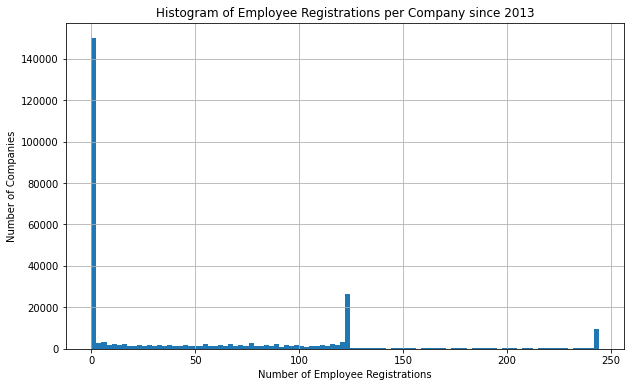

In [120]:
# count the number of registraitons per company
df_employee_from2013 = df_employee_from2013.groupby('CVR').size().reset_index().rename(columns={0: 'Registrations'})

# left join onto company_info, replace NaN with 0
company_info = company_info.merge(df_employee_from2013, how='left', left_on='CVR', right_on='CVR')
company_info['Registrations'] = company_info['Registrations'].fillna(0)

# plot the distribution of employee registrations
plt.figure(figsize=(10, 6))
company_info.Registrations.hist(bins=100)

plt.xlabel('Number of Employee Registrations')
plt.ylabel('Number of Companies')
plt.title('Histogram of Employee Registrations per Company since 2013')

# save fig
plt.savefig(os.path.join(save_path, 'EmployeeRegistrationsHistogram.png'))

In [121]:
company_info.Registrations.value_counts(normalize=True)

0.0      0.521474
122.0    0.092654
244.0    0.031160
121.0    0.007436
2.0      0.005841
           ...   
214.0    0.000461
190.0    0.000432
206.0    0.000390
158.0    0.000383
182.0    0.000305
Name: Registrations, Length: 184, dtype: float64

In [123]:
company_info.Registrations.describe()

count    282156.000000
mean         45.626076
std          65.511725
min           0.000000
25%           0.000000
50%           0.000000
75%          90.000000
max         244.000000
Name: Registrations, dtype: float64

In [124]:
del df_employee

### **2. Event type:** *Production Units*

All the geographical places where a company performs some activity must be registered as a production unit. 
We are interested in knowing:
1. How often do we see a production unit event (either closing an existing or registering a new unit)
2. Investigate if certain industries are more present than others. (Group by industry code, eg. present top and bottom 5)

In [154]:
# load the data
produnit_folder = r'/Users/nikolaibeckjensen/Dropbox/Virk2Vec/Tables/ProductionUnits'
df_produnit = load_all_chunks_from_folder(produnit_folder)


In [155]:
# calculate the share of active companies with 1 production unit
share = company_info.loc[company_info.EndDate.isna()].ProductionUnits.value_counts(normalize=True).loc[1]
print(f"Share of active companies with 1 active production unit: {share}")

company_info.ProductionUnits.describe()

Share of active companies with 1 active production unit: 0.9503764439171338


count    282156.000000
mean          1.136549
std           2.885988
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         777.000000
Name: ProductionUnits, dtype: float64

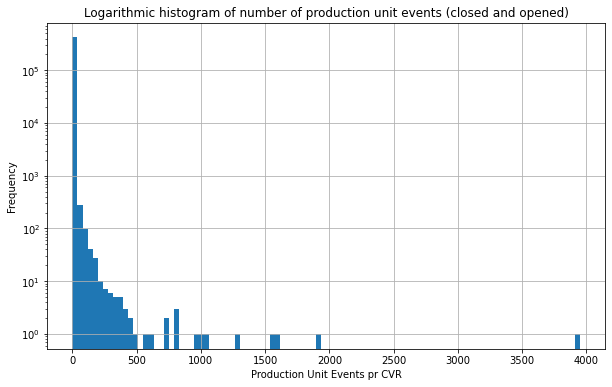

In [165]:
plt.figure(figsize=(10, 6))
df_produnit.CVR.value_counts().reset_index().CVR.hist(bins=100, log=True)
plt.xlabel('Production Unit Events pr CVR')
plt.ylabel('Frequency')
plt.title('Logarithmic histogram of number of production unit events (closed and opened)')

plt.savefig(os.path.join(save_path, 'ProductionUnitEventsHistogram.png'))

### **3. Event type:** *Registrations*

In [243]:
# load the data
reg_folder = r'/Users/nikolaibeckjensen/Dropbox/Virk2Vec/Tables/Registrations'
df_reg = load_all_chunks_from_folder(reg_folder)

In [244]:
df_company_type_changes = df_reg.loc[df_reg.ChangeType == 'CompanyType'].groupby('CVR').size().reset_index().rename(columns={0: 'CompanyTypeChanges'})

#### **3a.** Company type changes

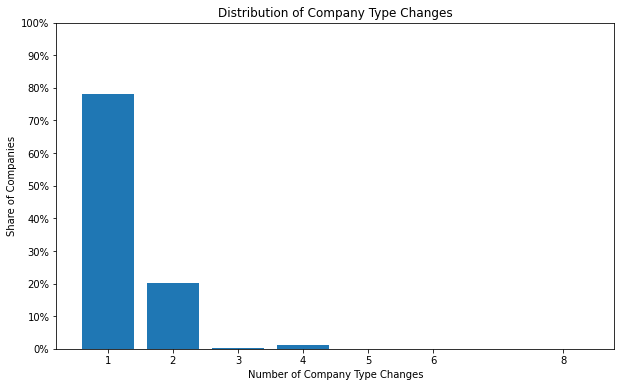

In [245]:
x = df_company_type_changes.CompanyTypeChanges.value_counts(normalize=True).values 
y = df_company_type_changes.CompanyTypeChanges.value_counts(normalize=True).index

# plot the distribution of company type changes
plt.figure(figsize=(10, 6))
plt.bar(y, x)
plt.xlabel('Number of Company Type Changes')
plt.ylabel('Share of Companies')
plt.yticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']);
plt.xticks(y)
plt.title('Distribution of Company Type Changes')

# save fig
plt.savefig(os.path.join(save_path, 'CompanyTypeChanges.png'))



In [246]:
cvrs_with_type_changes = df_company_type_changes.loc[df_company_type_changes.CompanyTypeChanges > 1].CVR.to_list()
data = df_reg.loc[(df_reg.ChangeType == 'CompanyType') & (df_reg.CVR.isin(cvrs_with_type_changes))].sort_values(['CVR', 'FromDate'])


In [250]:
type_changes = {}
for cvr in cvrs_with_type_changes:
    # fetch a sorted list of company types for the given cvr
    company_types = data.loc[data.CVR == cvr].NewValue.tolist()

    for i in range(len(company_types) - 1):


        if company_types[i] == 'APS' and company_types[i+1] == 'APS':
            print(cvr)
            break

        key = company_types[i] + " -> " + company_types[i+1]
        if key in type_changes:
            type_changes[key] += 1
        else:
            type_changes[key] = 1

10000157
10001803
10002729
10003067
10003466
10004055
10004969
10005043
10005655
10005817
10006414
10006953
10007062
10007267
10008166
10008662
10009367
10009561
10011264
10011337
10012066
10012171
10012759
10013062
10013755
10014476
10014786
10015715
10016193
10017769
10020468
10021219
10022568
10023084
10023769
10024846
10025567
10026164
10026342
10026717
10026830
10026881
10027063
10027322
10027365
10027608
10027764
10027861
10028183
10028248
10028264
10028302
10029155
10029457
10029511
10029724
10030110
10030129
10030463
10030617
10031028
10031265
10031761
10032563
10035252
10037522
10037565
10037921
10038669
10039363
10039959
10040019
10040159
10040396
10040469
10041929
10042658
10043115
10043239
10044227
10045061
10045827
10047056
10048761
10048818
10048826
10049490
10050723
10050960
10051029
10052750
10053439
10054915
10055091
10057329
10057868
10058015
10058112
10059909
10060060
10060818
10061512
10062020
10062624
10062926
10063124
10064066
10064821
10065127
10065569
10065615
1

KeyboardInterrupt: 

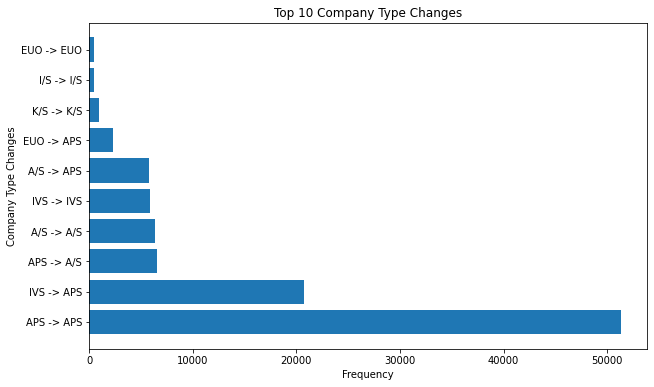

In [152]:
# plot a sorted bar chart of company type changes
type_changes = dict(sorted(type_changes.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.barh(list(type_changes.keys()), list(type_changes.values()))  # Swap x and y axis
plt.xlabel('Frequency')
plt.ylabel('Company Type Changes')
plt.title('Top 10 Company Type Changes')

# save fig
plt.savefig(os.path.join(save_path, 'Top10CompanyTypeChanges.png'))


In [153]:
for cvr in cvrs_with_type_changes:
    # fetch a sorted list of company types for the given cvr
    company_types = data.loc[data.CVR == cvr].NewValue.tolist()

    for i in range(len(company_types) - 1):
        key = company_types[i] + " -> " + company_types[i+1]

        if company_types[i] == 'APS' and company_types[i+1] == 'APS':
            print(cvr)
            break

10000157
10001803
10002729
10003067
10003466
10004055
10004969
10005043
10005655
10005817
10006414
10006953
10007062
10007267
10008166
10008662
10009367
10009561
10011264
10011337
10012066
10012171
10012759
10013062
10013755
10014476
10014786
10015715
10016193
10017769
10020468
10021219
10022568
10023084
10023769
10024846
10025567
10026164
10026342
10026717
10026830
10026881
10027063
10027322
10027365
10027608
10027764
10027861
10028183
10028248
10028264
10028302
10029155
10029457
10029511
10029724
10030110
10030129
10030463
10030617
10031028
10031265
10031761
10032563
10035252
10037522
10037565
10037921
10038669
10039363
10039959
10040019
10040159
10040396
10040469
10041929
10042658
10043115
10043239
10044227
10045061
10045827
10047056
10048761
10048818
10048826
10049490
10050723
10050960
10051029
10052750
10053439
10054915
10055091
10057329
10057868
10058015
10058112
10059909
10060060
10060818
10061512
10062020
10062624
10062926
10063124
10064066
10064821
10065127
10065569
10065615
1

KeyboardInterrupt: 

#### **3b.** Industry code changes

Look at only the first 4 digits

/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_60099/2008296987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_industry_type_changes['IndustryCode4'] = df_industry_type_changes.NewValue.astype(int).astype(str).str[:4]


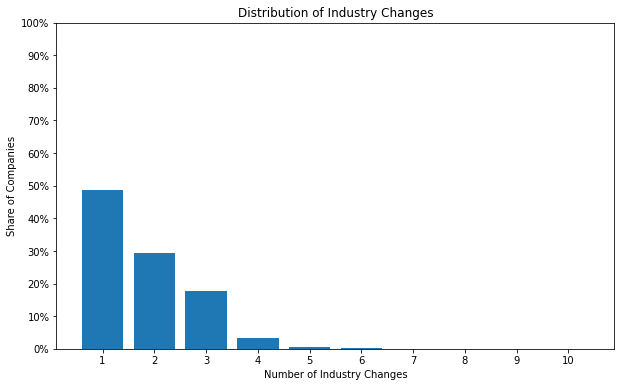

In [142]:
df_industry_type_changes = df_reg.loc[df_reg.ChangeType == 'Industry']
df_industry_type_changes['IndustryCode4'] = df_industry_type_changes.NewValue.astype(int).astype(str).str[:4]
df_industry_type_changes = df_industry_type_changes.drop_duplicates(subset=['CVR', 'IndustryCode4'])


df_industry_type_changes = df_industry_type_changes.groupby('CVR').size().reset_index().rename(columns={0: 'IndustryTypeChanges'})
x = df_industry_type_changes.IndustryTypeChanges.value_counts(normalize=True).values 
y = df_industry_type_changes.IndustryTypeChanges.value_counts(normalize=True).index

# plot the distribution of company type changes
plt.figure(figsize=(10, 6))
plt.bar(y, x)
plt.xlabel('Number of Industry Changes')
plt.ylabel('Share of Companies')
plt.yticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']);
plt.xticks(y)
plt.title('Distribution of Industry Changes')

# save fig
plt.savefig(os.path.join(save_path, 'IndustryTypeChanges.png'))


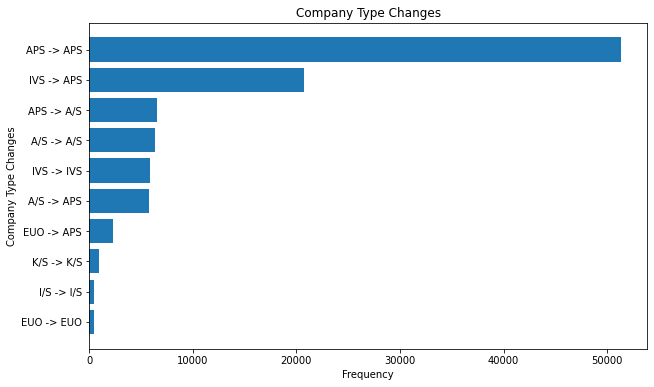

In [143]:
# plot a sorted bar chart of company type changes
type_changes = dict(sorted(type_changes.items(), key=lambda item: item[1], reverse=False))

plt.figure(figsize=(10, 6))
plt.barh(list(type_changes.keys()), list(type_changes.values()))  # Swap x and y axis
plt.xlabel('Frequency')
plt.ylabel('Company Type Changes')
plt.title('Company Type Changes')

# save fig
plt.savefig(os.path.join(save_path, 'CompanyTypeChangesSorted.png'))


In [144]:
cvrs_with_industry_changes = df_industry_type_changes.loc[df_industry_type_changes.IndustryTypeChanges > 1].CVR.to_list()
data = df_reg.loc[(df_reg.ChangeType == 'Industry') & (df_reg.CVR.isin(cvrs_with_industry_changes))].sort_values(['CVR', 'FromDate'])
data['IndustryCode4'] = data.NewValue.astype(int).astype(str).str[:4]

type_changes = {}
for cvr in cvrs_with_type_changes:
    # fetch a sorted list of company types for the given cvr
    industry_types = data.loc[data.CVR == cvr].IndustryCode4.tolist()

    for i in range(len(industry_types) - 1):
        key = industry_types[i] + " -> " + industry_types[i+1]
        if key in type_changes:
            type_changes[key] += 1
        else:
            type_changes[key] = 1

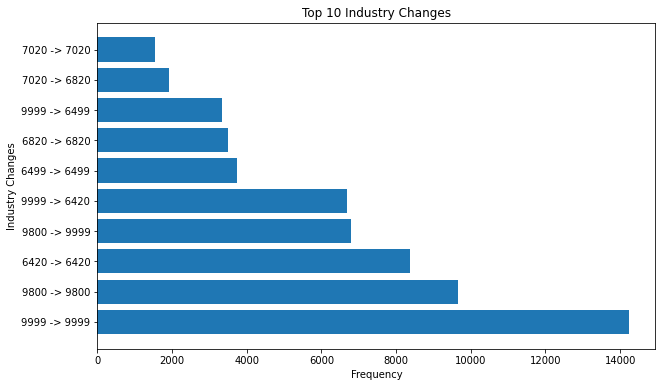

In [145]:
type_changes = dict(sorted(type_changes.items(), key=lambda item: item[1], reverse=False))

top_10_type_changes = dict(sorted(type_changes.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.barh(list(top_10_type_changes.keys()), list(top_10_type_changes.values()))  # Swap x and y axis
plt.xlabel('Frequency')
plt.ylabel('Industry Changes')
plt.title('Top 10 Industry Changes')

# save fig
plt.savefig(os.path.join(save_path, 'Top10IndustryChanges.png'))


In [182]:
df_reg_from2013

,CVR,FromDate,ChangeType,NewValue,year_int
0,37598143,2016-03-27,Name,G.A.B. 2 IVS,2016
1,37598143,2016-03-27,Address,2300,2016
2,37598143,2018-12-20,Address,1862,2018
3,37598143,2016-03-27,CompanyType,IVS,2016
4,37598143,2016-03-27,Industry,471110,2016
...,...,...,...,...,...
101222,42735051,2021-10-06,CompanyType,APS,2021
101223,42735051,2021-10-06,Industry,642020,2021
101224,42735051,2021-10-06,Capital,40000.0,2021
101225,42735051,2021-10-06,Status,NORMAL,2021


#### **3d.** Change in Address

Text(0.5, 1.0, 'Logarithmic histogram of number of registrations per company since 2013')

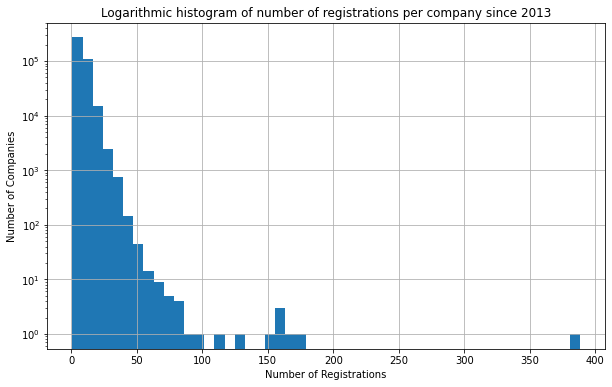

In [173]:
df_reg = df_reg.dropna(subset='FromDate')
df_reg['year_int'] = df_reg.FromDate.str[:4].astype(int)
df_reg_from2013 = df_reg[df_reg.year_int >= 2013]

# count the number of registraitons per company
plt.figure(figsize=(10, 6))
df_reg_from2013.groupby('CVR').size().reset_index().rename(columns={0: 'Registrations'}).Registrations.hist(bins=50, log=True)
plt.xlabel('Number of Registrations')
plt.ylabel('Number of Companies')
plt.title('Logarithmic histogram of number of registrations per company since 2013')

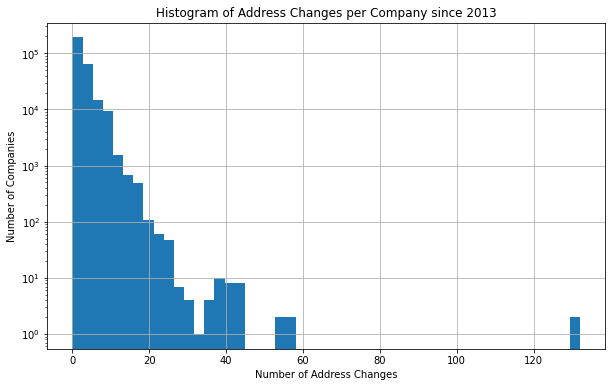

In [177]:
# number of address changes per company since 2013
df_address_changes = df_reg_from2013.loc[df_reg_from2013.ChangeType == 'Address']
df_address_changes = df_address_changes.groupby('CVR').size().reset_index().rename(columns={0: 'AddressChanges'})

# group onto company_info
company_info = company_info.merge(df_address_changes, how='left', left_on='CVR', right_on='CVR')
company_info['AddressChanges'] = company_info['AddressChanges'].fillna(0)



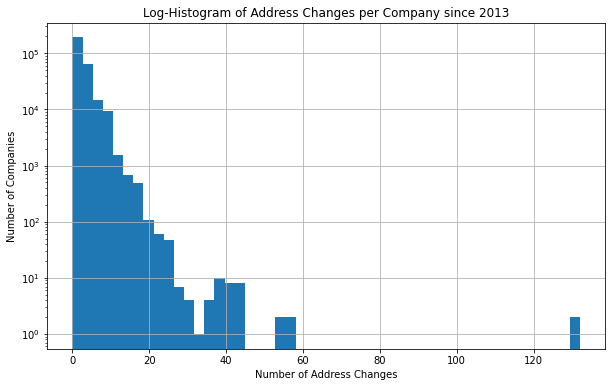

In [178]:
# plot the distribution of address changes
plt.figure(figsize=(10, 6))
company_info.AddressChanges.hist(bins=50, log=True)
plt.xlabel('Number of Address Changes')
plt.ylabel('Number of Companies')
plt.title('Log-Histogram of Address Changes per Company since 2013')

# save fig
plt.savefig(os.path.join(save_path, 'AddressChangesHistogram.png'))

In [180]:
company_info.AddressChanges.describe()

count    282157.000000
mean          2.290742
std           2.471037
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         132.000000
Name: AddressChanges, dtype: float64

#### **3c.** Capital/investments - TODO

In [192]:
df_capitalfrom2013 = df_reg_from2013.loc[df_reg_from2013.ChangeType == 'Capital']
df_capitalfrom2013['NewValue'] = df_capitalfrom2013['NewValue'].astype(float)

/var/folders/q1/1q4ncmgd7qz50d0x1z41czmh0000gn/T/ipykernel_60099/1276274991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_capitalfrom2013['NewValue'] = df_capitalfrom2013['NewValue'].astype(float)


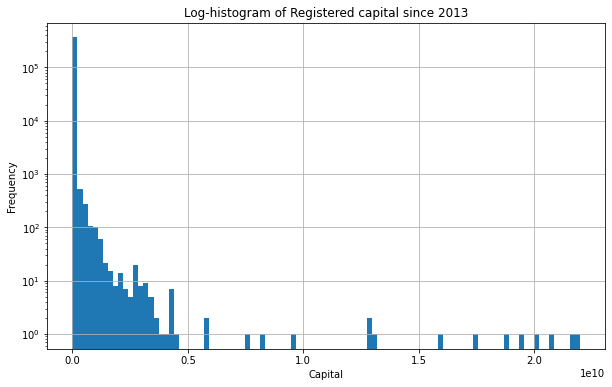

In [200]:
plt.figure(figsize=(10, 6))
df_capitalfrom2013.NewValue.hist(bins=100,log=True)

plt.xlabel('Capital')
plt.ylabel('Frequency')
plt.title('Log-histogram of Registered capital since 2013')

# save fig
plt.savefig(os.path.join(save_path, 'CapitalHistogram.png'))


In [203]:
# join onto company_info to compute number of capital registrations per company
df_capital_changes = df_capitalfrom2013.groupby('CVR').size().reset_index().rename(columns={0: 'CapitalChanges'})
company_info = company_info.merge(df_capital_changes, how='left', left_on='CVR', right_on='CVR')
company_info['CapitalChanges'] = company_info['CapitalChanges'].fillna(0)


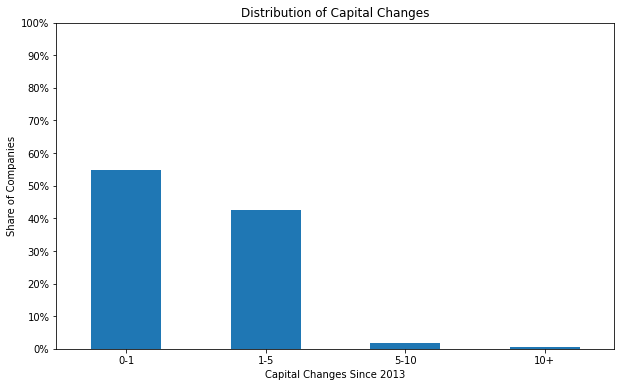

In [209]:
custom_bins = ['0-1', '1-5', '5-10', '10+']
company_info['CapitalChangesGroup'] = pd.cut(company_info['CapitalChanges'], bins=[0, 1, 5, 10, 100], labels=custom_bins)

# plot the distribution of capital changes
plt.figure(figsize=(10, 6))
company_info['CapitalChangesGroup'].value_counts(normalize=True).loc[custom_bins].plot(kind='bar')
plt.yticks(np.array(range(0,11))*0.1, ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']);
plt.xlabel('Capital Changes Since 2013')
plt.ylabel('Share of Companies')
plt.title('Distribution of Capital Changes')
plt.xticks(rotation=0)

# save fig
plt.savefig(os.path.join(save_path, 'CapitalChangesDistribution.png'))


In [210]:
del df_reg

### **4. Event type:** *Participants*

In [211]:
participants_path = r'/Users/nikolaibeckjensen/Dropbox/Virk2Vec/Tables/Participants'
df_participants = load_all_chunks_from_folder(participants_path)

In [225]:
df_participants

,CVR,EntityID,Name,ParticipantType,RelationType,Participation,Date,EquityPct
0,37598143,4004134708,Ümüt Cakmak,PERSON,DIREKTØR,entry,2016-03-27,NaN
1,37598143,4004134708,Ümüt Cakmak,PERSON,DIREKTØR,exit,2017-12-28,NaN
2,37598143,4004134708,Ümüt Cakmak,PERSON,STIFTERE,entry,2016-03-27,NaN
3,37598143,4004134708,Ümüt Cakmak,PERSON,STIFTERE,exit,2018-12-28,NaN
4,37598143,4004134708,Ümüt Cakmak,PERSON,EJERANDEL,entry,2016-03-27,1.0
...,...,...,...,...,...,...,...,...
136620,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,DIREKTØR,entry,2021-10-06,NaN
136621,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,DIREKTØR,exit,2024-08-19,NaN
136622,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,STIFTERE,entry,2021-10-06,NaN
136623,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,EJERANDEL,entry,2021-10-06,1.0


In [228]:
df_participants = df_participants.dropna(subset=['Date'])
df_participants['year_int'] = df_participants.Date.str[:4].astype(int)
registrationsfrom2013 = df_participants[df_participants.year_int >= 2013]
print("Number of participant registrations since 2013: ", len(registrationsfrom2013))

Number of participant registrations since 2013:  4550639


In [229]:
df_participants

,CVR,EntityID,Name,ParticipantType,RelationType,Participation,Date,EquityPct,year_int
0,37598143,4004134708,Ümüt Cakmak,PERSON,DIREKTØR,entry,2016-03-27,NaN,2016
1,37598143,4004134708,Ümüt Cakmak,PERSON,DIREKTØR,exit,2017-12-28,NaN,2017
2,37598143,4004134708,Ümüt Cakmak,PERSON,STIFTERE,entry,2016-03-27,NaN,2016
3,37598143,4004134708,Ümüt Cakmak,PERSON,STIFTERE,exit,2018-12-28,NaN,2018
4,37598143,4004134708,Ümüt Cakmak,PERSON,EJERANDEL,entry,2016-03-27,1.0,2016
...,...,...,...,...,...,...,...,...,...
136620,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,DIREKTØR,entry,2021-10-06,NaN,2021
136621,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,DIREKTØR,exit,2024-08-19,NaN,2024
136622,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,STIFTERE,entry,2021-10-06,NaN,2021
136623,42735051,4003878819,Signe Cathrine Kjøller Tønnesen,PERSON,EJERANDEL,entry,2021-10-06,1.0,2021


In [214]:
df_participants.ParticipantType.value_counts(normalize=True)

PERSON            0.782748
VIRKSOMHED        0.166823
ANDEN_DELTAGER    0.050429
Name: ParticipantType, dtype: float64

In [ ]:
registrationsfrom2013

In [233]:
df_participants.loc[df_participants.ParticipantType == 'ANDEN_DELTAGER'].RelationType.value_counts(normalize=True)[:10]

BESTYRELSESMEDLEM    0.296124
EJERANDEL            0.262212
DIREKTØR             0.121005
FORMAND              0.109028
BESTYRELSE           0.053163
STIFTERE             0.044022
ADM. DIR.            0.036999
DIREKTION            0.025132
formand              0.017061
NÆSTFORMAND          0.009548
Name: RelationType, dtype: float64

In [223]:
df_participants.loc[df_participants.ParticipantType == 'VIRKSOMHED'].RelationType.value_counts()[:25]

EJERANDEL                              755709
STIFTERE                               310596
INTERESSENTER                           14282
KOMPLEMENTARER                           3432
DIREKTØR                                 1713
DAGLIG LEDELSE                           1138
RevisionsvirksomhedStemmeberettiget       620
ADM. DIR.                                 188
SUPPLEANT                                 168
FORRETNINGSFØRER                          119
ADMINISTRATOR                             110
DIREKTION                                  86
BESTYRELSESMEDLEM                          76
TEGNINGSBERETTIGEDE                        72
LEDELSE                                    70
ANSVARLIG DELTAGER                         50
BÆREDYGTIGHEDSREVISION                     46
UKENDT                                     42
KOMPLEMENTAR                               28
BESTYRELSE                                 26
TEGNINGSBERETTIGET                         22
FORMAND                           

In [236]:
df_participants.loc[df_participants.RelationType == 'STIFTERE'].Participation.value_counts(normalize=True)

entry    0.747573
exit     0.252427
Name: Participation, dtype: float64

In [237]:
df_participants.loc[(df_participants.RelationType == 'STIFTERE') & (df_participants.CVR == 29140774)]

,CVR,EntityID,Name,ParticipantType,RelationType,Participation,Date,EquityPct,year_int
92977,29140774,28680856,HENNING BECK-NIELSEN HOLDING ApS,VIRKSOMHED,STIFTERE,entry,2005-10-07,NaN,2005
92978,29140774,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,STIFTERE,entry,2005-10-07,NaN,2005


In [238]:
df_participants.loc[df_participants.EntityID == 28680864]

,CVR,EntityID,Name,ParticipantType,RelationType,Participation,Date,EquityPct,year_int
127543,32569544,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,STIFTERE,entry,2009-11-05,NaN,2009
127544,32569544,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,EJERANDEL,entry,2009-11-05,0.10,2009
112887,42876976,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,EJERANDEL,entry,2022-03-29,0.05,2022
112888,42876976,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,EJERANDEL,exit,2022-08-31,0.05,2022
112889,42876976,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,EJERANDEL,entry,2022-09-01,0.05,2022
92978,29140774,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,STIFTERE,entry,2005-10-07,NaN,2005
15607,33035454,28680864,RASMUS STIG JENSEN HOLDING ApS,VIRKSOMHED,EJERANDEL,entry,2020-02-15,0.10,2020
